# Red Queen trajectories

This Jupyter Notebook produced Figure 1 for "The short life of the Red Queen" with the default parameters. 

By changing the parameters other trajectories can also be displayed.



### Methods to choose from:

* dtPC         &ensp; - pairwise comparison (discrete time)
* dtMoran      &ensp; - (discrete time)
* PC
* Moran        &ensp; - this one takes a very long time (attractive fixed point)
* SCPS         &ensp; - (4D)
* logIR        &ensp; - (4D)
* IR           &ensp; - (4D) mu = 0, no host competition




### **Parameters:**

You can change the following parameters from the logIR models.
The parameters define the system's fixed points and therefore the initial population size.

In [142]:
methods              = ['Moran', 'IR']   # choose at least two methods


death_P              = 1.                # death rate 
birth_H_original     = 6                 # birth rate 
lam0                 = 4                 # interaction strength of h and p
carrying_capacity_LV = 100               # carrying capacity

### Technical details:

Comment out the seeding lines to get completely differnt random numbers every time.
Increase emergency_t_max if you cannot see a type dying out.

In [143]:
import numpy as np
import random
import math
from all_transition_functions_methods import *
import matplotlib.pyplot as plt

seed_value      = 10                                # for different initialisatons of the random number generator
np.random.seed(seed_value)


methods_2d      = ['dtPC', 'dtMoran', 'PC', 'Moran']# constant population size models are 2D
methods_4d      = ['SCPS', 'logIR']                 # only these are 4D (logIR includes IR with mu=0)
emergency_t_max = 5000000                           # emergency end simulation

### Further definitions and calculations:

logIR system defines fixed points and population size

In [144]:
birth_H = birth_H_original
lam     = lam0 / carrying_capacity_LV        # infection rate scaled with carrying capacity 
mu      = birth_H / carrying_capacity_LV     # competition rate is birth rate scaled with carrying capacity
h_star  = death_P / lam                       
p_star  = birth_H / lam * (1 - 2 * (h_star) * (mu / birth_H))  
N_H     = round(2 * h_star)  # total host population
N_P     = round(2 * p_star)  # total parasite population
N       = N_H + N_P          # total number of all species
w_H     = 0.5
w_P     = 1.

### Definition of the Bimatrix-Game:
Moran, PC and SCPS systems are based on Game Theory

In [145]:
# Game:
alpha = 1                                           # impact of matching type (p1 (p2) infects h1 (h2))
beta  = 0                                           # impact of cross-infection (p1 (p2) infects h2 (h1))
Mh    = np.array([[beta, alpha], [alpha, beta]])    # impact of parasite on host Mh = - Mp ^ T + alpha + beta
Mp    = np.array([[alpha, beta], [beta, alpha]])    # impact of host on parasite                   

### Plot options:

Colours

### Technical details:

Comment out the seeding lines to get completely differnt random numbers every time.
Increase emergency_t_max if you cannot see a type dying out.

In [146]:
import numpy as np
import random
import math
from all_transition_functions_methods import *
import matplotlib.pyplot as plt

seed_value      = 10                                # for different initialisatons of the random number generator
np.random.seed(seed_value)


methods_2d      = ['dtPC', 'dtMoran', 'PC', 'Moran']# constant population size models are 2D
methods_4d      = ['SCPS', 'logIR']                 # only these are 4D (logIR includes IR with mu=0)
emergency_t_max = 5000000                           # emergency end simulation

In [147]:
colour_Nh = '#126180'
colour_Np = '#6c3082' 
colours_h = ['#267f53', '#70d4a2']
colours_p = ['#c44082', '#d470a2'] 
fs = 14

### Run:

Loop through both methods to calculate evolutionary dynamics over time. Additional population dynamics only change for the 4D models that allow a changing population size.
If you re-run this cell without re-seeding the results will look different.

method:  Moran
w_H 0.5
w_P 1.0
method:  IR
w_H 0.5
w_P 1.0


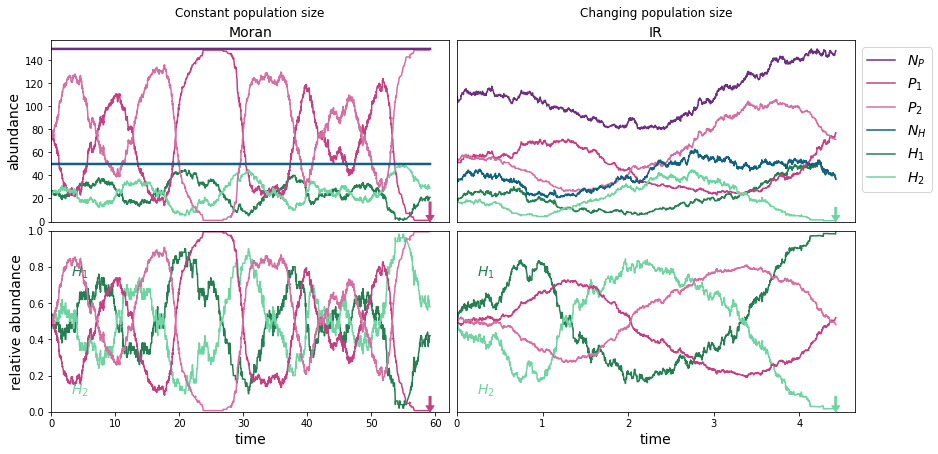

In [148]:
fig,  all_ax  = plt.subplots(nrows=2, ncols=len(methods), figsize=[12,6])

for index_method, method in enumerate(methods):   ### LOOP THROUGH METHODS
    print('method: ', method)
    print('w_H', w_H)
    print('w_P', w_P)

    ax     = all_ax[0,index_method]  # plot trajectories in time
    ax_rel = all_ax[1,index_method]  # plot p1 against h1

    if method == 'IR':
        method = 'logIR'
        mu = 0                       # set competition to 0 
        birth_H = birth_H_original/2.         # rescale
    else:
        birth_H = birth_H_original   # reset
        
    # for dtMoran/Moran and dtPC/PC (2d methods) we can precompute the transition probabilities 
    # because the population size stays constant the transition matrices are constant
    # the function returns 'nan' for methods scps and logIR
    tr = transitions(method, N_H, N_P, Mh, Mp, w_H, w_P) 
    # -------------------------------------------- START SIMULATION ---------------------------------
    nh_0  = int(N_H / 2);    np_0  = int(N_P / 2);    nh_02 = int(N_H / 2);      np_02 = int(N_P / 2);      
    n_h   = 1 * nh_0;        n_p   = 1 * np_0;        n_h2  = 1 * nh_02;         n_p2  = 1 * np_0;
    x     = [int(N_H / 2)];  y     = [int(N_P / 2)];  x2    = [nh_02];           y2    = [np_0]

    time = np.array([0])
    alive = 1
    while alive == 1 and time[-1]<emergency_t_max:  # run as long as there is no extincion

        # use precomputed transition rates/probabilities or compute current 4d rates
        # and compare these probabilities with a random number (for moran and local_update) 
        # or use the rates in a gillespie algorithm
        # then update new values of h an p

        if method in methods_2d:
            current_probabilities = tr[:, n_h, n_p]
            # this is the actual update where a (pseudo-)random number is used
            delta_h, delta_p, delta_t = update(method, current_probabilities)  

            n_p += delta_p  # update all values
            n_h += delta_h

            if any([n_h == 0, n_h == N_H, n_p == 0, n_p == N_P]):  # check whether all types are alive
                alive = 0

        elif method in methods_4d:
            if method == 'SCPS':
                current_probabilities = current_transitions_4d_scps(n_h, n_h2, n_p, n_p2, w_H, w_P, alpha, beta)
            else:
                current_probabilities = current_transitions_4d_IR(n_h, n_h2, n_p, n_p2, birth_H, death_P, mu, lam)
            
            # this is the actual update where a (pseudo-)random number is used:
            delta_h, delta_h2, delta_p, delta_p2, delta_t = update_4d(current_probabilities)  

            n_p  += delta_p   # update all values
            n_h  += delta_h
            n_p2 += delta_p2
            n_h2 += delta_h2
            x2.append(n_h2)
            y2.append(n_p2)
            
            if any([n_h2 == 0, n_h == 0, n_p2 == 0, n_p == 0]):  # check whether all types are alive
                alive = 0
        else:
            print('this method does not exist')
            quit()

        x.append(n_h)
        y.append(n_p)

        time = np.append(time, time[-1]+delta_t) # append time

    # -----------------------------------------------------------------------------------------------------------
    #### PLOT

    ax.plot(time, x, color = colours_h[0]) 
    ax.plot(time, y, color = colours_p[0]) 
    if method in methods_2d:  # 2d
        ax.plot(time, [N_H-i for i in x], color = colours_h[1]) 
        ax.plot(time, [N_P-j for j in y], color = colours_p[1])
        ax.plot(time, [N_H   for i in x], color = colour_Nh, linewidth=2.5) 
        ax.plot(time, [N_P   for j in y], color = colour_Np, linewidth=2.5) 
        ax_rel.plot(time, [i / N_H   for i in x], color = colours_h[0])
        ax_rel.plot(time, [1 - i/N_H for i in x], color = colours_h[1])
        ax_rel.plot(time, [i / N_P   for i in y], color = colours_p[0])
        ax_rel.plot(time, [1 - i/N_P for i in y], color = colours_p[1])
    elif method in methods_4d:  # 4d
        ax.plot(time, x2, color = colours_h[1]) 
        ax.plot(time, y2, color = colours_p[1]) 
        ax.plot(time, [xi + xj for xi, xj in zip(x, x2)], color = colour_Nh) 
        ax.plot(time, [yi + yj for yi, yj in zip(y, y2)], color = colour_Np)
        ax_rel.plot(time, [i / (i+j) for i, j in zip(x, x2)], color = colours_h[0])
        ax_rel.plot(time, [i / (i+j) for i, j in zip(x2, x)], color = colours_h[1])
        ax_rel.plot(time, [i / (i+j) for i, j in zip(y,  y2)] , color = colours_p[0])
        ax_rel.plot(time, [i / (i+j) for i, j in zip(y2, y)], color = colours_p[1])

    
    # -----------------------------------------------------------------------------------------------------------------------------------
    ### final plot options
    if n_h    == 0:
        coldead = colours_h[0]
    elif n_p  == 0:
        coldead = colours_p[0]
    elif n_h2 == 0:
        coldead = colours_h[1]
    elif n_p2 == 0:
        coldead = colours_p[1]
    else:
        coldead = 'white'
    ax.annotate("",xy=(time[-1], 0), xycoords='data',
                xytext=(time[-1], 17), textcoords='data',
                arrowprops=dict(headlength=6,headwidth=8,width=2, color = coldead), color = coldead)
    ax_rel.annotate("",xy=(time[-1], 0), xycoords='data',
                    xytext=(time[-1], 17/200), textcoords='data',
                    arrowprops=dict(headlength=6,headwidth=8,width=2, color = coldead), color = coldead)
    ax_rel.set_xlim(ax.get_xlim())
    if index_method == 0:
        ax.set_ylabel(r'abundance', fontsize = fs)
        ax_rel.set_ylabel(r'relative abundance', fontsize = fs)
    else:
        ax.yaxis.set_visible(False)
        ax_rel.yaxis.set_visible(False)
    
    if method in methods_2d:
        ax.annotate(r'Constant population size', xy = (0.5, 1.15), va="center", ha="center", xycoords = "axes fraction", fontsize = fs-2)
        ax.annotate(method, xy = (0.5, 1.045), va="center", ha="center", xycoords = "axes fraction", fontsize = fs)
    else:
        ax.annotate(r'Changing population size', xy = (0.5, 1.15), va="center", ha="center", xycoords = "axes fraction", fontsize = fs-2)
        if mu==0 and method=='logIR':
            method = 'IR'
        ax.annotate(method, xy = (0.5, 1.045), va="center", ha="center", xycoords = "axes fraction", fontsize = fs)

    ax_rel.annotate(r'$H_1$', xy = (0.05, 0.75), xycoords = "axes fraction", color = colours_h[0], fontsize = fs)
    ax_rel.annotate(r'$H_2$', xy = (0.05, 0.1), xycoords = "axes fraction", color = colours_h[1], fontsize = fs)
    ax.set_xlim(left = 0);    ax.set_ylim(bottom = 0);    ax.get_xaxis().set_ticks([])
    ax_rel.set_xlabel(r'time', fontsize = fs);    ax_rel.set_ylim([0,1]);    ax_rel.set_xlim(left = 0)

# legend
ax.plot([],[],color = colour_Np,   label=r'$N_P$'); ax.plot([],[],color = colours_p[0],label=r'$P_1$')
ax.plot([],[],color = colours_p[1],label=r'$P_2$'); ax.plot([],[],color = colour_Nh,   label=r'$N_H$')
ax.plot([],[],color = colours_h[0],label=r'$H_1$'); ax.plot([],[],color = colours_h[1],label=r'$H_2$')
ax.legend(bbox_to_anchor=(1,1),  loc="upper left", fontsize=fs)
fig.subplots_adjust(right = 0.99, left = 0.06, bottom = 0.08, top = 0.94, wspace = 0.02, hspace = 0.05)
